<a href="https://colab.research.google.com/github/BarbaLoira/Analysis-Essays-NLP/blob/master/Analysis_of_essays_with_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install uol-redacoes-xml

In [2]:
!pip install git+https://github.com/gpassero/uol-redacoes-xml.git

  Cloning https://github.com/gpassero/uol-redacoes-xml.git to /tmp/pip-req-build-wvsr5de_
  Stored in directory: /tmp/pip-ephem-wheel-cache-f4ynx0tt/wheels/1b/d6/69/d465fd205ecd2058fe620852fb31bdf5cd0b9697ec2d7548eb
Successfully built uol-redacoes-xml


#import and load uol_redacoes_xml

In [3]:
import nltk
nltk.download('punkt')
import uol_redacoes_xml

essays = uol_redacoes_xml.load()
# print(len(essays)) #~2000

# print(essays[0].text) #texto original da primeira redação

# print(  [attr for attr in essays[0].__dir__() if not attr.startswith('_')]   ) # exibe os atributos do objeto de redação (exceto os privados, que começam com '_')

 



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


UOL essays load warnings: 
No text  ->  3
Final score != from sum of criteria score  ->  45
Not 5 criteria  ->  7
Total warnings: 55


#Imports Useful

In [0]:
from sklearn.model_selection import cross_validate 
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn import datasets

from uol_redacoes_xml.reader.commons import kfold_cross_validation

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import spacy
#!python -m spacy download pt
nlp = spacy.load('pt')


import pyphen
#!pip install pyphen
#dic = pyphen.Pyphen(lang='pt')
#dic.inserted('macaco')
pyphenPt = pyphen.Pyphen(lang='pt')

#!pip install textstat
from textstat.textstat import legacy_round 

 

#formatando o texto

In [148]:
variables  = ['title', 'text' , 'final_score' ]
data = [ [getattr(i,attr) for attr in essays[0].__dir__() if not attr.startswith('_') and not attr.startswith('prompt') and not attr.startswith('url') and not attr.startswith('fixed_text') and not attr.startswith('errors') and not attr.startswith('get_features') and not attr.startswith('comments') and not attr.startswith('criteria_scores') ] for i in essays]

text_formatted = pd.DataFrame(data ,columns = variables )
text_formatted
#text_formatted.head()
#text_formatted.tail()
#text_formatted["text"][0]

,title,text,final_score
0,Conflito entre liberdade de expressão e intimi...,"A liberdade de expressão, assim como o direito...",5.0
1,Entre direitos individuais e escândalos políticos,Os direitos fundamentais contidos na Constitui...,6.5
2,"O freio na liberdade, para uma maior liberdade","Ao se falar em liberdade de expressão, é impos...",2.5
3,Privilégio à informação,Sabe-se que o cidadão tem direito à privacidad...,2.5
4,Limites entre Direitos,A liberdade de expressão e o direito a vida pr...,5.0
5,Direitos em conflito,A liberdade de expressão é um direito expresso...,7.0
6,O conflito entre a liberdade de expressão e o ...,O direito à livre expressão e a intimidade são...,2.5
7,Direitos em conflito: liberdade de expressão e...,Existe um conflito entre o direito à liberdade...,4.5
8,Liberdade de expressão e intimidade/limites pe...,É notório que a liberdade de expressão deve se...,0.0
9,A intimidade supera a liberdade de expressão,A liberdade de expressão é um direito constitu...,4.5


#Main

In [138]:
resultFlesch = [flesch_reading_ease(row["text"]) for index, row in text_formatted.iterrows()]
#test com texto facil
#flesch_reading_ease('O Doutor Armando foi até a esquina esperá o filho que chegava da escola. Nisso, a Maria ficou em casa preparando o almoço.Quando eles chegarão em casa a Maria tava na cozinha preparando a famosa receita da família boa pra caramba o bolo de fubá cremoso.')

resultFlesch




[42.17,
 28.42,
 8.55,
 27.41,
 35.74,
 11.08,
 43.56,
 35.95,
 61.17,
 23.87,
 54.71,
 58.03,
 47.21,
 41.03,
 54.86,
 45.71,
 30.1,
 12.27,
 24.11,
 46.26,
 40.52,
 66.32,
 32.4,
 46.26,
 52.7,
 64.14,
 48.78,
 42.99,
 58.48,
 55.37,
 27.66,
 34.26,
 33.4,
 57.22,
 43.65,
 46.85,
 69.91,
 54.46,
 -11.77,
 44.41,
 36.92,
 58.01,
 31.17,
 59.38,
 52.62,
 54.15,
 62.51,
 46.19,
 54.05,
 18.07,
 64.36,
 50.84,
 38.92,
 18.02,
 42.72,
 53.24,
 57.81,
 46.69,
 43.99,
 49.43,
 37.91,
 38.43,
 50.73,
 51.3,
 60.04,
 6.51,
 63.52,
 58.38,
 26.14,
 33.45,
 53.88,
 40.69,
 47.84,
 18.65,
 56.36,
 44.93,
 45.59,
 40.69,
 56.2,
 26.01,
 44.18,
 44.12,
 17.79,
 54.22,
 16.19,
 38.49,
 72.63,
 39.77,
 65.3,
 50.25,
 44.31,
 35.44,
 33.78,
 43.96,
 17.68,
 53.21,
 37.53,
 46.44,
 48.61,
 43.56,
 41.99,
 31.48,
 27.01,
 44.07,
 22.42,
 40.88,
 46.22,
 20.95,
 43.82,
 38.43,
 27.15,
 30.54,
 23.57,
 39.2,
 42.81,
 47.68,
 48.42,
 43.42,
 51.11,
 53.42,
 75.76,
 44.92,
 28.21,
 21.65,
 40.69,
 32.23,
 

#Util Text

In [0]:
def break_sentences(text):   
    doc = nlp(text)
    return list(doc.sents) 
  
# Returns Number of Words in the text 
def word_count(text): 
    sentences = break_sentences(text) 
    words = 0
    for sentence in sentences: 
        words += len([token for token in sentence]) 
    return words 
  
# Returns the number of sentences in the text 
def sentence_count(text): 
    sentences = break_sentences(text) 
    return len(sentences)  
  
  
  # Returns average sentence length 
def avg_sentence_length(text): 
    words = word_count(text) 
    sentences = sentence_count(text) 
    average_sentence_length = float(words / sentences) 
    return average_sentence_length 
  
def syllables_count(word): 
    return len((pyphenPt.inserted(word)).split("-"))
  
  
  # Returns the average number of syllables per 
# word in the text 
def avg_syllables_per_word(text): 
    syllable = syllables_count(text) 
    words = word_count(text) 
    ASPW = float(syllable) / float(words) 
    return legacy_round(ASPW, 1) 
  
  
# Return total Difficult Words in a text 
def difficult_words(text): 
  
    # Find all words in the text 
    words = [] 
    sentences = break_sentences(text) 
    for sentence in sentences: 
        words += [str(token) for token in sentence] 
  
    # difficult words are those with syllables >= 2 
    # easy_word_set is provide by Textstat as  
    # a list of common words 
    diff_words_set = set() 
      
    for word in words: 
        syllable_count = syllables_count(word) 
        if word not in easy_word_set and syllable_count >= 2: 
            diff_words_set.add(word) 
  
    return len(diff_words_set) 
  
# A word is polysyllablic if it has more than 3 syllables 
# this functions returns the number of all such words  
# present in the text 
def poly_syllable_count(text): 
    count = 0
    words = [] 
    sentences = break_sentences(text) 
    for sentence in sentences: 
        words += [token for token in sentence] 
      
  
    for word in words: 
        syllable_count = syllables_count(word) 
        if syllable_count >= 3: 
            count += 1
    return count 
  
  # muito facil        75 a 100     (primeiros 4 anos escolares)
  # facil              50 a 75      (quita a oitava serie)
  # pouco dificil      25 a 50      (colegial e o nivel superior)
  # muito dificil   abaixo de 25    (texto academico) 
def flesch_reading_ease(text): 
    """ 
        Implements Flesch Formula: 
        Reading Ease score = 206.835 - (1.015 × ASL) - (84.6 × ASW) 
        Here, 
          ASL = average sentence length (number of words  
                divided by number of sentences) 
          ASW = average word length in syllables (number of syllables  
                divided by number of words) 
    """
    FRE = 206.835 - float(1.015 * avg_sentence_length(text)) - float(84.6 * avg_syllables_per_word(text)) 
    return legacy_round(FRE, 2)   
  

#Util Graph

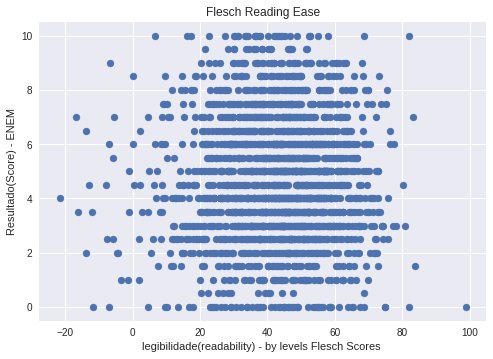

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~marcosedu/0 or inside your plot.ly account where it is named 'basic_table'


In [176]:
# libraries
import matplotlib.pyplot as plt
import numpy as np

 
import plotly 
plotly.tools.set_credentials_file(username='marcosedu', api_key='veFgO1eqvVlfc2SWkLNW')
import plotly.plotly as py
import plotly.graph_objs as go

# use the scatter function
plt.scatter(resultFlesch,text_formatted["final_score"])
plt.title("Flesch Reading Ease")
plt.xlabel("legibilidade(readability) - by levels Flesch Scores ")
plt.ylabel("Resultado(Score) - ENEM")
plt.show()

 
trace = go.Table(
    header=dict(values=['Results', 'Levels']),
    cells=dict(values=[[' 75 a 100 ', '50 a 75 ', '25 a 50', 'abaixo de 25'],
                       ['muito facil (primeiros 4 anos escolares)', 'facil (quita a oitava serie)',
                        'pouco dificil (colegial a o nivel superior)', 'muito dificil (texto academico) ']]))

data = [trace] 
py.iplot(data, filename = 'basic_table')




#References

* **readability formulas applied to textbooks inbrazilian portuguese**
[link text](http://www.nilc.icmc.usp.br/nilc/download/Reltec28.pdf)

* **Como consentir sem entender?**
[link text](http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-42302009000300028)

* **Índices de Legibilidade de Flesch-Kincaid 
e de Facilidade de Leitura de Flesch**
[link text](https://www.ufrgs.br/bioetica/ilfk.htm)

* **Mineração de Texto Aplicada na Análise de Redações do ENEM**
[link text](http://www.bcc.ufrpe.br/content/minera%C3%A7%C3%A3o-de-texto-aplicada-na-an%C3%A1lise-de-reda%C3%A7%C3%B5es-do-enem)
